# Extracting the core position and the position of the laser

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import os
import cv2
from scipy import optimize

base_dir = '/home/aquiles/Data/Dispertech/Data/Auto_Alignment_Data'

list_cartridges = []  # List of cartridges to analyse

print('This are the available cartridges to extract positions:')
for root, dirs, files in os.walk(base_dir):
    for name in dirs:
        print(name)
        list_cartridges.append(name)

This are the available cartridges to extract positions:
fiber_end_2001001_0.npy
fiber_end_2001001_1.npy
fiber_end_2001001_2.npy
fiber_end_2001001_3.npy
fiber_end_2001002_0.npy
fiber_end_2001002_1.npy
fiber_end_2001003_0.npy
fiber_end_2001003_1.npy
fiber_end_2001004_0.npy
fiber_end_2001005_0.npy
microscope_2001001_0.npy
microscope_2001001_1.npy
microscope_2001001_2.npy
microscope_2001001_3.npy
microscope_2001001_4.npy
microscope_2001002_0.npy
microscope_2001003_0.npy
microscope_2001003_1.npy
microscope_2001004_0.npy
microscope_2001004_1.npy
microscope_2001005_0.npy
microscope_2001005_1.npy
movie_2001001_0.h5
movie_2001001_1.h5
movie_2001001_3.h5
movie_2001002_0.h5
movie_2001003_0.h5
movie_2001004_0.h5
movie_2001005_0.h5
movie_2001005_1.h5


In [116]:
def gaussian(height, center_x, center_y, width_x, width_y):
    """Returns a gaussian function with the given parameters"""
    width_x = float(width_x)
    width_y = float(width_y)
    return lambda x,y: height*np.exp(
                -(((center_x-x)/width_x)**2+((center_y-y)/width_y)**2)/2)

def moments(data):
    """Returns (height, x, y, width_x, width_y)
    the gaussian parameters of a 2D distribution by calculating its
    moments """
    total = data.sum()
    X, Y = np.indices(data.shape)
    x = (X*data).sum()/total
    y = (Y*data).sum()/total
    col = data[:, int(y)]
    width_x = np.sqrt(np.abs((np.arange(col.size)-y)**2*col).sum()/col.sum())
    row = data[int(x), :]
    width_y = np.sqrt(np.abs((np.arange(row.size)-x)**2*row).sum()/row.sum())
    height = data.max()
    return height, x, y, width_x, width_y

def fitgaussian(data):
    """Returns (height, x, y, width_x, width_y)
    the gaussian parameters of a 2D distribution found by a fit"""
    params = moments(data)
    errorfunction = lambda p: np.ravel(gaussian(*p)(*np.indices(data.shape)) -
                                 data)
    p, success = optimize.leastsq(errorfunction, params)
    return p

def plot_fiber_end(data, x=None, y=None, crop_size=15):
    if x is None:
        x = 500
    if y is None:
        y = 500

    fig, ax = plt.subplots(1, 2, figsize=(18,10), dpi=100)
    fig.set()
    ax[0].imshow(data.T)
    ax[0].axhline(y=y,color='red')
    ax[0].axvline(x=x,color='red')

    cropped_data = np.copy(data[x-crop_size:x+crop_size, y-crop_size:y+crop_size])
    cropped_data[cropped_data<np.mean(cropped_data)+np.std(cropped_data)] = 0
    p = fitgaussian(cropped_data)
    extracted_position = p[1]+x-crop_size, p[2]+y-crop_size
    print(x, y)
    print(extracted_position)
    ax[1].imshow(cropped_data)
    ax[1].axhline(y=p[1],color='red')
    ax[1].axvline(x=p[2],color='red')
    valid = False
    if np.sqrt((x-extracted_position[0])**2 + (y-extracted_position[1])**2) < 1:
        valid = True
    return extracted_position, valid

def plot_laser_position(data, make_plot=False):
    mask = data>np.mean(data.reshape(data.size,1))+np.std(data.reshape(data.size,1))
    M = cv2.moments(mask*data)
    cx = M['m10']/M['m00']
    cy = M["m01"] / M["m00"]
    print(cx, cy)
    if make_plot:
        fig, ax = plt.subplots(1, figsize=(11,10), dpi=100)
        fig.set()
        ax.imshow(mask.T)
        ax.axhline(y=cx,color='red')
        ax.axvline(x=cy,color='red')
    return (cy, cx) # The image is transposed compared to what we expect

In [139]:
cartridge = list_cartridges[6]
cartridge_folder = os.path.join(base_dir, cartridge)

laser_positions = []
fiber_ends = []

for file in os.listdir(cartridge_folder):
    if file.startswith('laser_position'):
        laser_positions.append(file)
    elif file.startswith('fiber_end'):
        fiber_ends.append(file)
        
print(f'There are {len(fiber_ends)} fiber end images')
print(f'There are {len(laser_positions)} laser position images')

There are 1 fiber end images
There are 12 laser position images


699 370
(699.3967182953486, 369.91918437239025)
Saving data


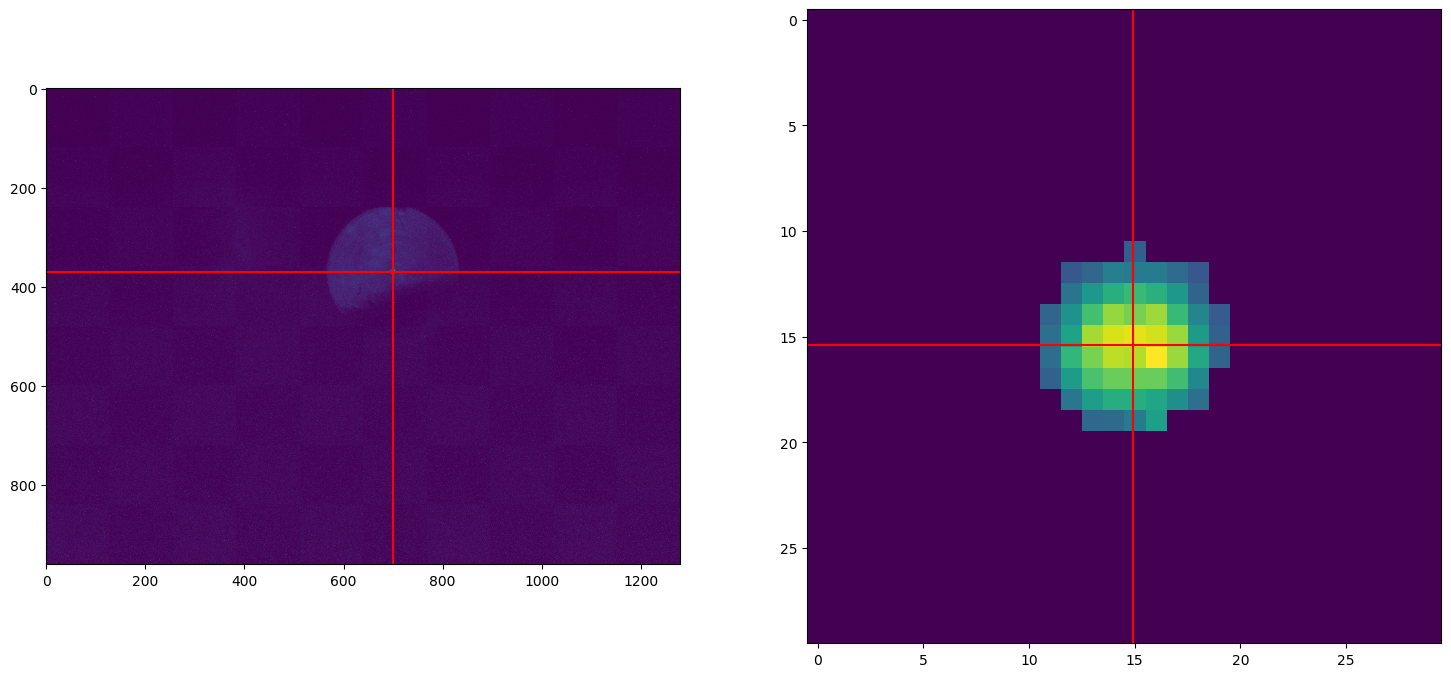

In [119]:
fiber_end = fiber_ends[0]
data = np.load(os.path.join(cartridge_folder, fiber_end))
center, valid = plot_fiber_end(data, 699, 370)
if valid:
    print('Saving data')
    filename = 'coordinates_' + fiber_end
    
    np.save(os.path.join(base_dir, filename), center)

In [140]:
centers = np.zeros((len(laser_positions), 2))

for i, laser_position in enumerate(laser_positions):
    data = np.load(os.path.join(cartridge_folder, laser_position))
    centers[i][:] = plot_laser_position(data)

filename = 'laser_positions_' + cartridge + '.npy'
np.save(os.path.join(base_dir, filename), centers)

426.59333809145903 654.3545531048339
426.5522193281351 654.3511598185316
426.19379208416774 654.2713091753609
425.71090599423553 654.0006357847549
426.2219739924072 654.1730244638736
426.53400677858497 654.305872577011
426.48885767648704 654.2670466449841
426.57361410834034 654.4010685692699
426.37268108378015 654.3123323283558
426.61759842513305 654.3869537766374
426.4616366693967 654.2871984084126
426.1284240554916 654.20562729196


738 551
737.6946924550198 551.3894237478837


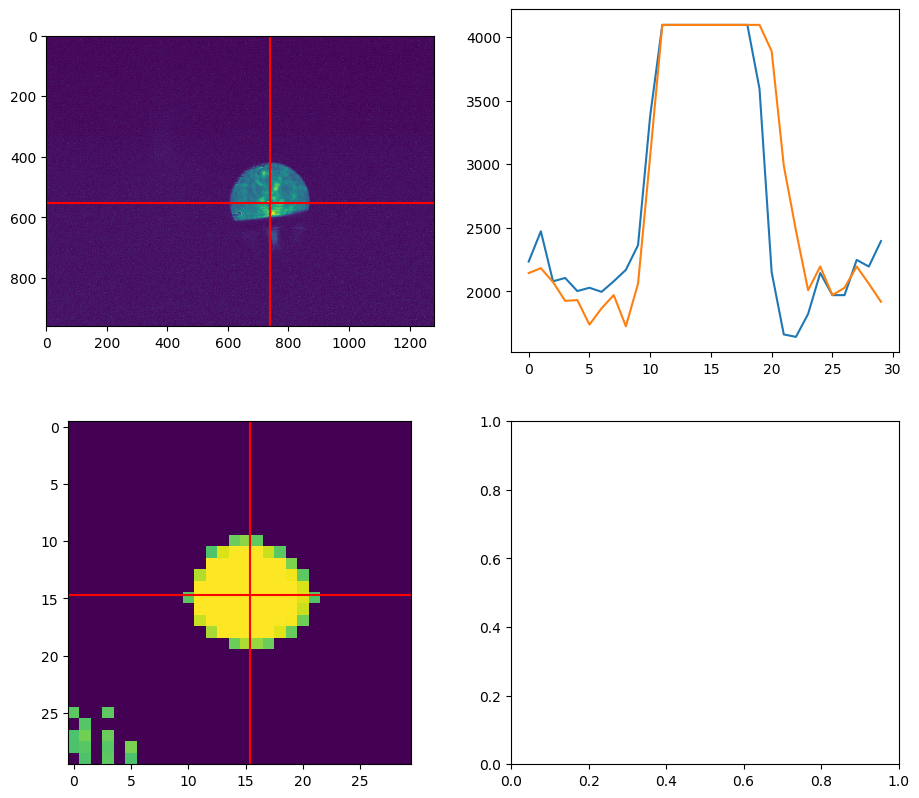

In [13]:
file = "fiber_end_1902019_0.npy"
filename = os.path.join(base_dir,file)
data = np.load(os.path.join(base_dir, filename))
fig, ax = plt.subplots(2, 2, figsize=(11,10), dpi=100)
fig.set()
y = 551
x = 738
crop_size = 15

ax[0][0].imshow(data.T)
ax[0][0].axhline(y=y,color='red')
ax[0][0].axvline(x=x,color='red')
ax[0][1].plot(data[x-crop_size:x+crop_size,y])
ax[0][1].plot(data[x,y-crop_size:y+crop_size])

cropped_data = np.copy(data[x-crop_size:x+crop_size, y-crop_size:y+crop_size])
cropped_data[cropped_data<np.mean(cropped_data)+np.std(cropped_data)] = 0
p = fitgaussian(cropped_data)
print(x, y)
print(p[1]+x-crop_size, p[2]+y-crop_size)
ax[1][0].imshow(cropped_data)
ax[1][0].axhline(y=p[1],color='red')
ax[1][0].axvline(x=p[2],color='red')

In [42]:
ddd = np.load(os.path.join(base_dir, 'laser_positions_1902123.npy'))
print(ddd)

[[625.52175393 481.89642024]
 [625.62311246 482.01364107]
 [625.57636705 482.10991345]
 [625.46299166 481.75621101]
 [625.42025112 481.85664387]
 [625.33617106 481.71535715]]


431.63584298258496 675.9325632462874


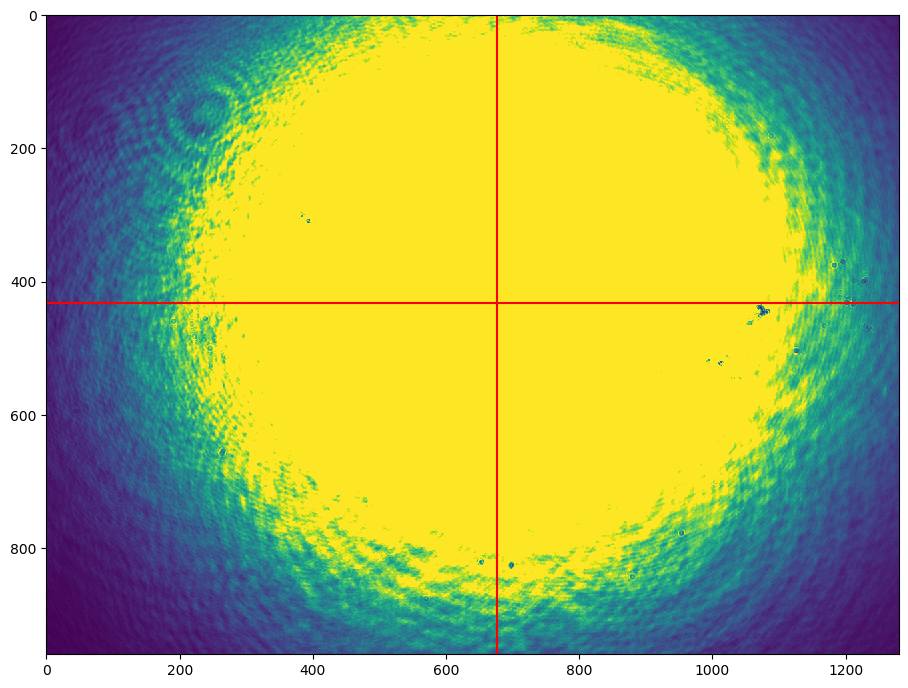

In [15]:
file = 'laser_position_1902019_0.npy'
data = np.load(os.path.join(base_dir, file))

mask = data>np.mean(data.reshape(data.size,1))#+np.std(data.reshape(data.size,1))
M = cv2.moments(mask*data)
cx = M['m10']/M['m00']
cy = M["m01"] / M["m00"]
print(cx, cy)

fig, ax = plt.subplots(1, figsize=(11,10), dpi=100)
fig.set()
ax.imshow(data.T)
ax.axhline(y=cx,color='red')
ax.axvline(x=cy,color='red')

In [121]:
# Let's calculate the averages and coordinate them in one data structure

cartridge_alignment_information = {}

for c in list_cartridges:
    fiber_end = np.load(os.path.join(base_dir, f'coordinates_fiber_end_{c}_0.npy'))
    laser_pos = np.mean(np.load(os.path.join(base_dir, f'laser_positions_{c}.npy')),0)
    cartridge_alignment_information.update({
        c: {'fiber_end': fiber_end, 'laser_pos': laser_pos}
    })

In [143]:
cartridge_alignment_information

{'1902123': {'fiber_end': array([686.40412279, 690.85191321]),
  'laser_pos': array([625.49010788, 481.89136446])},
 '1902130': {'fiber_end': array([770.68204526, 521.25214149]),
  'laser_pos': array([681.91622987, 416.55018655])},
 '1902073': {'fiber_end': array([729.2527328 , 382.58737341]),
  'laser_pos': array([680.66344342, 367.93094637])},
 '1902019': {'fiber_end': array([737.69469246, 551.38942375]),
  'laser_pos': array([675.31601318, 431.72126346])},
 '1902039': {'fiber_end': array([699.40891756, 369.97243149]),
  'laser_pos': array([669.93654107, 365.34030788])},
 '1902133': {'fiber_end': array([696.29902127, 454.44198563]),
  'laser_pos': array([668.54804922, 390.45164611])},
 '1902121': {'fiber_end': array([716.56627496, 535.58587392]),
  'laser_pos': array([654.2763985 , 426.37075402])}}

Text(0, 0.5, 'Laser Pos')

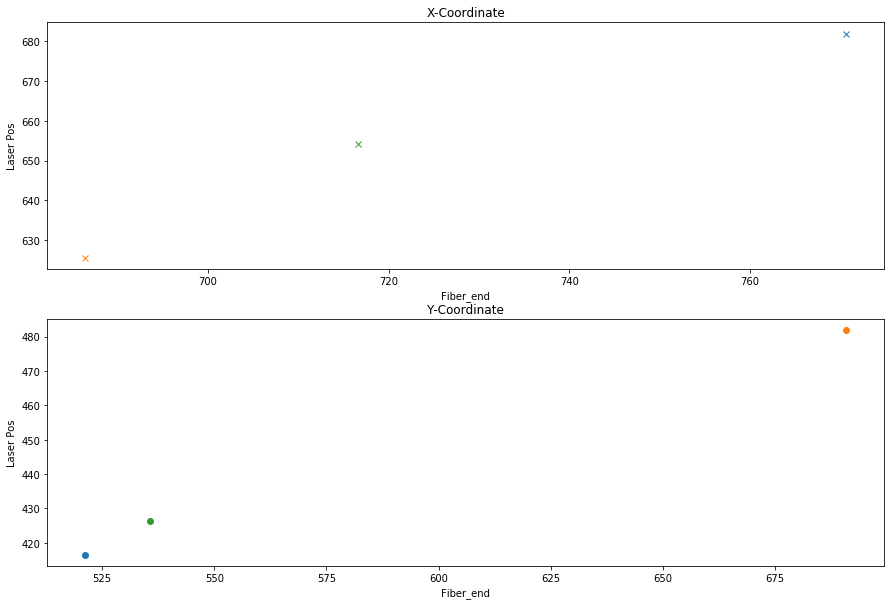

In [149]:
fig, ax = plt.subplots(2, figsize=(15,10))
cartridges_to_plot = cartridge_alignment_information.keys()
cartridges_to_plot = ['1902130', '1902123', '1902121']
for cartridge in cartridges_to_plot:
    fiber_end = cartridge_alignment_information[cartridge]['fiber_end']
    laser_pos = cartridge_alignment_information[cartridge]['laser_pos']
    ax[0].plot(fiber_end[0], laser_pos[0], 'x')
    ax[1].plot(fiber_end[1], laser_pos[1], 'o')
    
ax[0].set_title('X-Coordinate')
ax[0].set_xlabel('Fiber_end')
ax[0].set_ylabel('Laser Pos')
ax[1].set_title('Y-Coordinate')
ax[1].set_xlabel('Fiber_end')
ax[1].set_ylabel('Laser Pos')